# CS7.505: Computer Vision: Assignment 1: Camera Calibration


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Implement the DLT (Direct Linear Transformation) based calibration that we discussed in the class. You could use C/C++, Python or Matlab for this. However, you are expected to implement it yourselves and not use an existing implementation


In [2]:
def DLT_internal(world_cords, img_cords):
    N = len(world_cords)
    assert(N == len(img_cords))
    M = np.zeros((2*N, 12))
    for i in range(N):
        u, v = img_cords[i,0:2]
        M[2*i,11] = u
        M[2*i+1,11] = v
        M[2*i,3] = M[2*i+1, 7] = -1
        M[2*i+1,:4] = M[2*i,4:8] = 0
        M[2*i,:3] = M[2*i+1,4:7] = -world_cords[i,:3]
        M[2*i,8:11] = u * world_cords[i,:3]
        M[2*i+1,8:11] = v * world_cords[i,:3]
    U, S, V = np.linalg.svd(M)
    return V[11].reshape((3,4))

In [3]:
def DLT(world_cords, img_cords):
    V = DLT_internal(world_cords, img_cords)
    return V / V[-1,-1]

2. Implement the RANSAC based variant of the calibration that we discussed in the class. Note that these two algorithms use a set of known correspondences between real-world points and image points.


In [4]:
def project_pts(P, world_cords_homo):
    world_cords_homo = world_cords_homo.T
    img_pred = np.dot(P, world_cords_homo).T
    img_pred[img_pred[:,2] == 0,2] = 1e-9
    img_pred /= img_pred[:,2,None]
    return img_pred

In [5]:
def compute_error(P, world_cords_homo, img_cords):
    img_pred = project_pts(P, world_cords_homo)
    diff = img_pred[:,:2] - img_cords
    errors = np.square(diff)
    return np.sum(errors, axis=1)

In [6]:
def RANSAC(world_cords, img_cords, n_iter=100):
    N = len(world_cords)
    assert(N == len(img_cords))
    best_err = np.inf
    bestP = None
    for _ in range(n_iter):
        idx = np.arange(N)
        np.random.shuffle(idx)
        # randomly select minimum no of parameeters
        idx = idx[:6]
        newwc = wc[idx]
        newic = ic[idx]
        P = DLT_internal(newwc, newic)
        wc_homo = np.hstack((world_cords, np.ones((N,1))))
        err = compute_error(P, wc_homo, img_cords)
        # threshold
        thresh = err < 30
        if np.count_nonzero(thresh) < 7:
            continue
        newwc = wc[thresh.astype(bool)]
        newic = ic[thresh.astype(bool)]
        # print(newwc, newic)
        P = DLT_internal(newwc, newic)
        err = np.mean(compute_error(P, wc_homo, img_cords))
        if err < best_err:
            best_err = err
            bestP = P
    return bestP/bestP[-1,-1]

3. Use the image that is provided along with this assignment along with the real-world measurements that are given to you to compute the camera’s internal and external parameters using each of the above algorithms. Note that you need to manually estimate the image co-ordinates of the given world points. You may implement and use the Harris Corner detector to help select these points. Describe your observations regarding the results.


In [7]:
bd = cv2.imread('../data/black-dots.JPG', cv2.IMREAD_COLOR)
bd = cv2.cvtColor(bd, cv2.COLOR_BGR2RGB)

In [8]:
meas = cv2.imread('../data/measurements.jpg', cv2.IMREAD_COLOR)
meas = cv2.cvtColor(meas, cv2.COLOR_BGR2RGB)

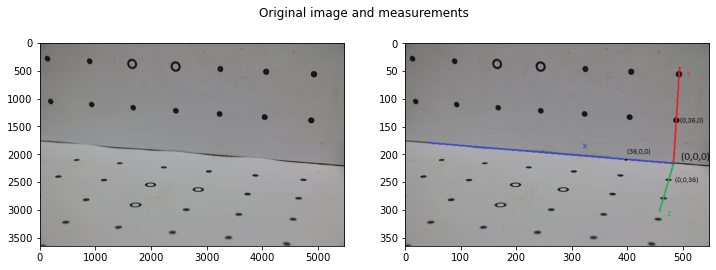

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
fig.suptitle("Original image and measurements")
ax1.imshow(bd)
ax2.imshow(meas)
plt.show()

In [10]:
wc = np.array([[0,0,36], [36,0,0], [72,72,0], [36,144,0], [0,36,72], [72,180,0], [0,144,108], [72,0,0], [0,144,36], [0,72,144]])
ic = np.array([[4728.0,2456.2], [4862.5,1380.0], [3236.7,467.3], [1664.3,1150.0], [3725.8,2713.0], [891.5,327.9], [828.3,2808.4], [4916.4,562.2], [1432.5,2160.0], [2378.2,3401.5]])

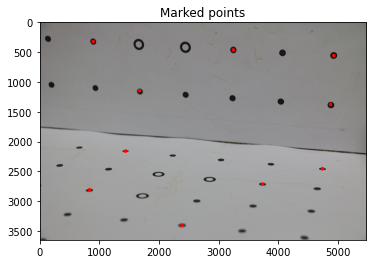

In [11]:
mark_bd = bd.copy()
for i in ic:
    mark_bd = cv2.circle(mark_bd, i.astype(int), radius=30, color=(255,0,0), thickness=-1)
plt.title("Marked points")
plt.imshow(mark_bd)
plt.show()

In [12]:
P_d = DLT(wc, ic)
print("P from DLT:\n", P_d)
wc_homo = np.hstack((wc, np.ones((len(wc),1))))
err = compute_error(P_d, wc_homo, ic)
print("Error(MSE):", np.mean(err))

P from DLT:
 [[-1.45747640e+00 -2.10587721e+01 -9.63317337e+00  4.80747133e+03]
 [-2.24702967e+01 -1.11719940e+00  4.51360264e+00  2.15683862e+03]
 [-6.04498406e-04  3.82265948e-04 -1.57281245e-03  1.00000000e+00]]
Error(MSE): 6.141961188825677


In [13]:
P_r = RANSAC(wc, ic, n_iter=1000)
print("P from RANSAC:\n", P_r)
wc_homo = np.hstack((wc, np.ones((len(wc),1))))
err = compute_error(P_r, wc_homo, ic)
print("Error(MSE):", np.mean(err))

P from RANSAC:
 [[-1.43827797e+00 -2.10734614e+01 -9.62137264e+00  4.80830734e+03]
 [-2.24351590e+01 -1.13133607e+00  4.53552567e+00  2.15667535e+03]
 [-5.95144085e-04  3.76833335e-04 -1.56577745e-03  1.00000000e+00]]
Error(MSE): 6.8995946127744485


In [14]:
def decompose_P(P):
    KR = P[:,:3]
    KRinv = np.linalg.inv(KR)
    minKRC = P[:,3]
    C = -np.dot(KRinv, minKRC)
    Rt, Kbinv = np.linalg.qr(-KRinv)
    R = Rt.T
    Kb = np.linalg.inv(Kbinv)
    K = Kb / Kb[-1,-1]
    return K, R, C

In [15]:
K, R, C = decompose_P(P_d)
print('Parameters for the DLT version')
print('K:\n', K)
print('R:\n', R)
print('C:\n', C)

Parameters for the DLT version
K:
 [[ 1.31602592e+04  8.67597327e+01  2.67383743e+03]
 [-0.00000000e+00 -1.31247847e+04  2.02899947e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R:
 [[-8.10299454e-04  9.71639744e-01  2.36464694e-01]
 [-9.36799239e-01 -8.34686765e-02  3.39764869e-01]
 [ 3.49866445e-01 -2.21244634e-01  9.10299007e-01]]
C:
 [207.69777189 -36.37009021 547.13706205]


In [16]:
K, R, C = decompose_P(P_r)
print('Parameters for the RANSAC version')
print('K:\n', K)
print('R:\n', R)
print('C:\n', C)

Parameters for the RANSAC version
K:
 [[ 1.32445564e+04  8.46671316e+01  2.70695735e+03]
 [-0.00000000e+00 -1.32005812e+04  1.97574018e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
R:
 [[-0.00160056  0.9720998   0.23456218]
 [-0.9379998  -0.08276643  0.3366097 ]
 [ 0.3466321  -0.21948051  0.91196189]]
C:
 [209.23053898 -37.29314794 550.15761069]


Observations:
1. We see that the DLT method gives a lower error as compared to the RANSAC varaint.
2. The parameters of camera matrix as computed by the DLT and RANSAC variant are numerically close.

4. Repeat the above experiments after correcting for radial distortion. Estimate the radial distortion parameters from the straight lines in the image. What do you observe regarding the resulting parameters?


In [17]:
gray = cv2.imread('../images/left01.jpg', cv2.IMREAD_GRAYSCALE)

In [18]:
g = np.meshgrid(np.arange(7), np.arange(6), 0)
vx, vy, vz = list(map(lambda x: x.flatten(), g)) 
wc_temp = np.vstack((vx, vy, vz)).T

In [19]:
ret, corners = cv2.findChessboardCorners(gray, (7,6), None)

In [20]:
wc_temp = np.array([wc_temp], 'f')
corners = np.array([corners], 'f')

In [21]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc_temp, corners, gray.shape[::-1], None, None)
if ret:
    print("Reprojection error from base image:\n", ret)
    print("K using openCV:\n", mtx)
    print("R using openCV:\n", rvecs)
    print("C using openCV:\n", tvecs)

Reprojection error from base image:
 0.2292095240594204
K using openCV:
 [[1.09888876e+03 0.00000000e+00 2.83911812e+02]
 [0.00000000e+00 9.62184057e+02 4.07279523e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
R using openCV:
 (array([[-0.80385406],
       [ 0.52664962],
       [-2.9425356 ]]),)
C using openCV:
 (array([[ 4.96702771],
       [-4.05089358],
       [29.18983767]]),)


In [22]:
h,  w = gray.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

dst = cv2.undistort(gray, mtx, dist, None, newcameramtx)
x, y, w, h = roi
crop = dst[y:y+h, x:x+w]

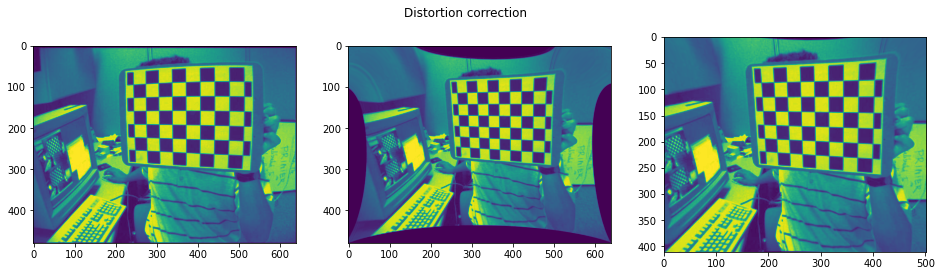

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 4))
fig.suptitle("Distortion correction")
ax1.imshow(gray)
ax2.imshow(dst)
ax3.imshow(crop)
plt.show()

In [24]:
g = np.meshgrid(np.arange(7), np.arange(6), 0)
vx, vy, vz = list(map(lambda x: x.flatten(), g)) 
wc_temp = np.vstack((vx, vy, vz)).T

In [25]:
ret, corners = cv2.findChessboardCorners(crop, (7,6), None)
corners = np.array([corners], 'f')
wc_temp = np.array([wc_temp], 'f')

In [26]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc_temp, corners, crop.shape[::-1], None, None)
print("Reprojection error from undistored image:", ret)

Reprojection error from undistored image: 0.1522930250627905


**Observations:**
1. We can see that the straight lines that we rounded in the first image are now straight in the undistored image.
2. The reprojection error decreases on undistoring the image

5. Use the real-world measurements that are provided along with the estimated camera parameters to compute the image of a wireframe of the object. Note that you will be computing the location of image points as xi = P.Xi, and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight lines between the computed points xi. What do you observe about the overlay?


In [27]:
x = np.arange(3) * 36
y1 = np.arange(7) * 36
y2 = np.arange(7) * 36
z = np.arange(5) * 36

In [28]:
g = np.meshgrid(x,y1,0,1)
vx, vy, vz, vw = list(map(lambda x: x.flatten(), g))
coords_up = np.vstack((vx, vy, vz, vw)).T

In [29]:
g = np.meshgrid(0,y2,z,1)
vx, vy, vz, vw = list(map(lambda x: x.flatten(), g))
coords_down = np.vstack((vx, vy, vz, vw)).T

In [30]:
pts_up = project_pts(P_d, coords_up)[:,:2]
pts_down = project_pts(P_d, coords_down)[:,:2]

In [31]:
pts_bd = bd.copy()
for i in pts_up:
    pts_bd = cv2.circle(pts_bd, i.astype(int), radius=30, color=(255,0,255), thickness=-1)
for i in pts_down:
    pts_bd = cv2.circle(pts_bd, i.astype(int), radius=30, color=(255,0,255), thickness=-1)


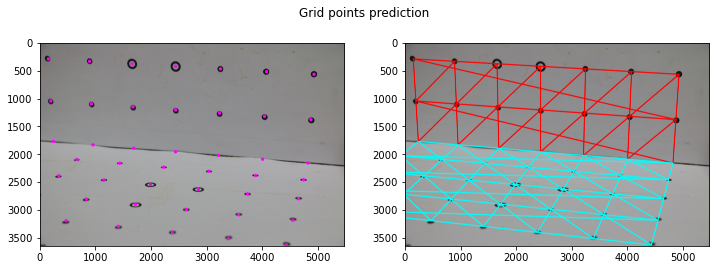

In [32]:
grid_bd = bd.copy()
for i, pt in enumerate(pts_up):
    grid_bd = cv2.line(grid_bd, pt.astype(int), pts_up[(i+3) % len(pts_up)].astype(int), color=(255,0,0), thickness=20)
    grid_bd = cv2.line(grid_bd, pt.astype(int), pts_up[(i+2) % len(pts_up)].astype(int), color=(255,0,0), thickness=20)

for i, pt in enumerate(pts_down):
    grid_bd = cv2.line(grid_bd, pt.astype(int), pts_down[(i+4) % len(pts_down)].astype(int), color=(0,255,255), thickness=20)
    grid_bd = cv2.line(grid_bd, pt.astype(int), pts_down[(i+5) % len(pts_down)].astype(int), color=(0,255,255), thickness=20)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))    
plt.suptitle("Grid points prediction")
ax1.imshow(pts_bd)
ax2.imshow(grid_bd)
plt.show()

6. Repeat the calibration of the camera using Zhang’s method using either the available OpenCV or Matlab implementation. How does your results compare with DLT based method?


In [33]:
import glob

g = np.meshgrid(np.arange(6), np.arange(8), 0)
vx, vy, vz = list(map(lambda x: x.flatten(), g)) 
wc_temp = np.vstack((vx, vy, vz)).T

ic = []
wc = []

filenames = glob.glob('../data/checkerboard-*.JPG')
for file in filenames:
    ret, corners = cv2.findChessboardCorners(cv2.imread(file), (6,8))
    if ret:
        ic.append(corners)
        wc.append(wc_temp)

ic = np.array(ic, 'f').squeeze()
wc = np.array(wc, 'f')
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc, ic, (5472, 3648), None, None)
print('Camera Matrix:\n', mtx)
print('Reprojection error:\n', ret)

Camera Matrix:
 [[1.36634770e+04 0.00000000e+00 3.33653558e+03]
 [0.00000000e+00 1.36813826e+04 1.49660054e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Reprojection error:
 2.481084983813769


In [34]:
P_d = DLT(wc[0], ic[0])
print("P from DLT:\n", P_d)
wc_homo = np.hstack((wc[0], np.ones((len(wc[0]),1))))
err = compute_error(P_d, wc_homo, ic[0])
print("Error(MSE):", np.mean(err))

P from DLT:
 [[nan nan nan nan]
 [nan nan nan nan]
 [nan nan inf nan]]
Error(MSE): nan


/tmp/ipykernel_163955/3893382687.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return V / V[-1,-1]
/tmp/ipykernel_163955/3893382687.py:3: RuntimeWarning: invalid value encountered in true_divide
  return V / V[-1,-1]


Hence we can see that DLT based method does not work on planar images

7. Repeat the overlay of wireframe using the internal parameters estimated from Zhang’s method. Describe your observations.


In [35]:
newPts = []
for i in range(len(wc)):
    pred, _ = cv2.projectPoints(wc[i], rvecs[i], tvecs[i], mtx, dist)
    newPts.append(pred)

newPts = np.array(newPts).reshape((-1, 2))

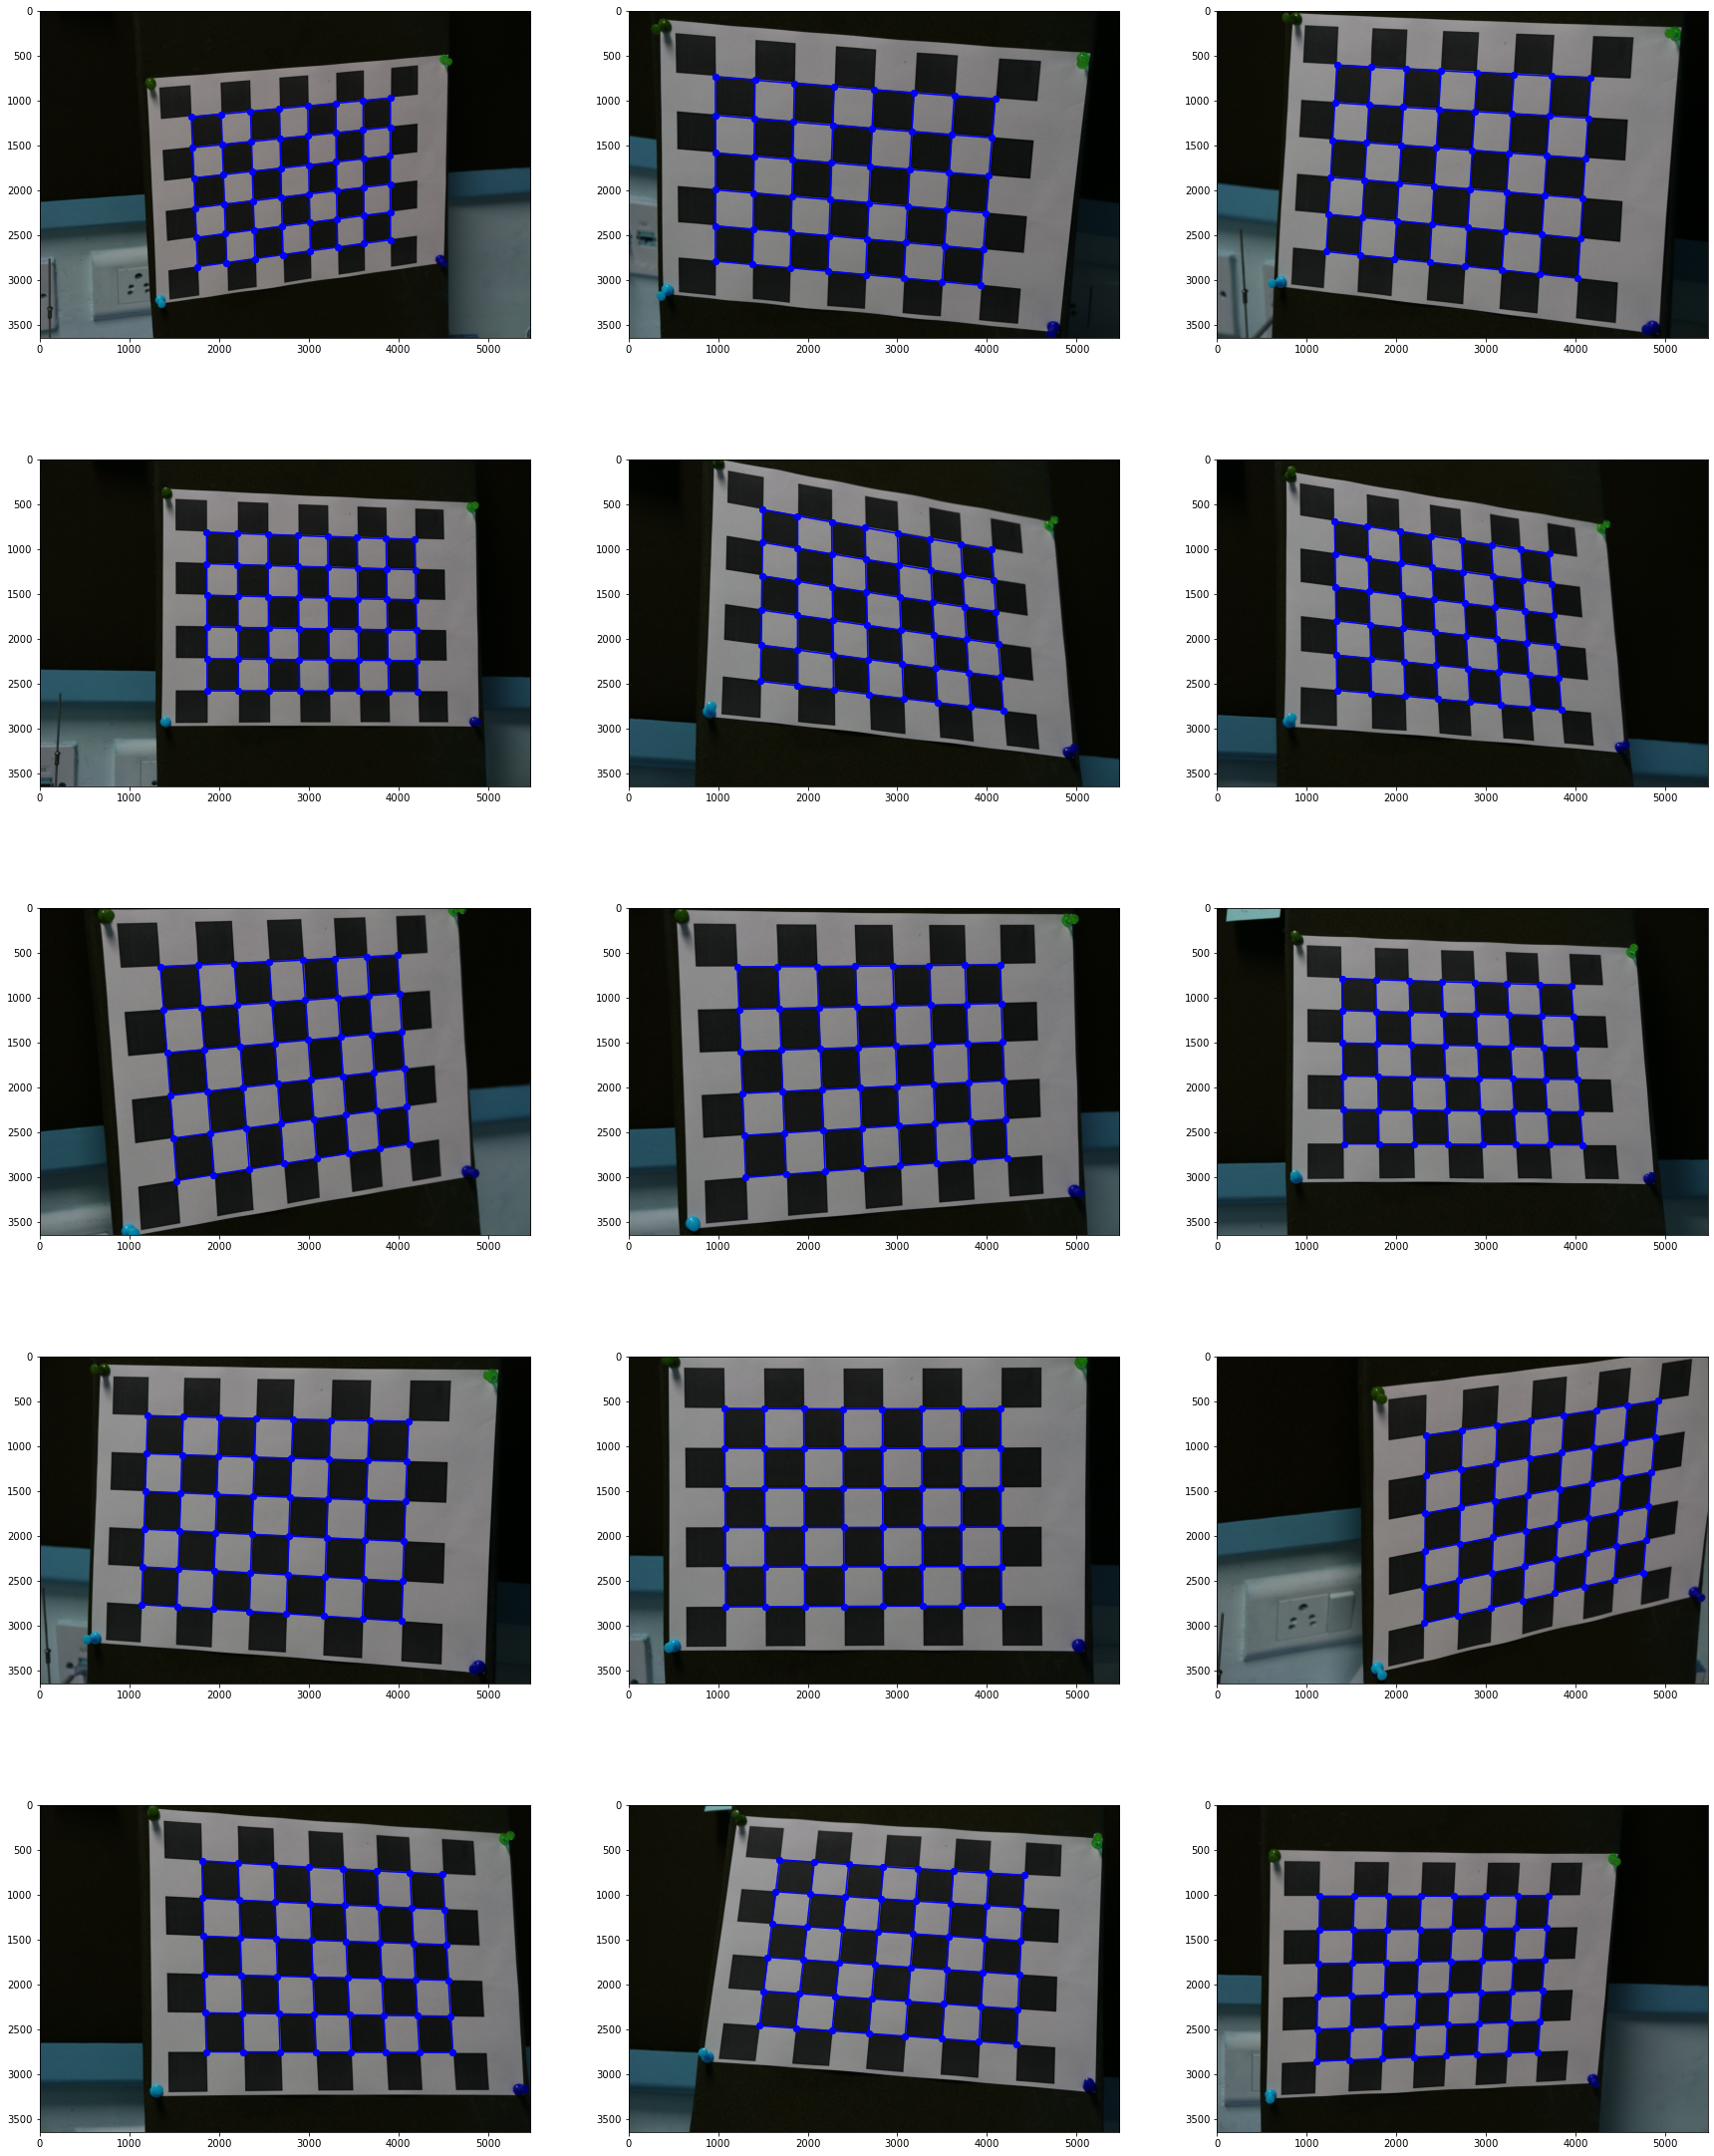

In [36]:
fig, ax = plt.subplots(5,3,figsize=(30, 40))

for i, file in enumerate(filenames):
    img = cv2.imread(file)
    # Making wireframe
    for j in range(8):
        ax[i//3, i%3].plot(newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 0], newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 1], 'bo-')
    for j in range(6):
        indices = np.arange(start=i * 48 + j, stop=(i + 1) * 48 + j, step=6)
        ax[i//3, i%3].plot(newPts[indices][:, 0], newPts[indices][:, 1], 'bo-')

    # Plotting
    ax[i//3, i%3].imshow(img)

plt.show()

9. Select a camera that you would like to use for the assignments. Note that you might be using this camera for future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera that you have access to


10. Repeat the 3 calibration methods using your own camera and your own calibration object for which you measure and determine the world co-ordinates. Use a printed checkerboard pattern for Zhang’s method. Describe and comment on the results of each method.


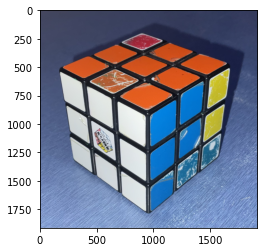

In [37]:
rubic = cv2.imread('../images/rubic.png', cv2.IMREAD_COLOR)
rubic = cv2.cvtColor(rubic, cv2.COLOR_BGR2RGB)
plt.imshow(rubic)
plt.show()

In [38]:
wc = np.array([[0,0,0],[0,1,0],[0,2,0],[1,0,0],[2,0,0],[0,0,1],[0,0,2], [2,2,0], [0,2,2], [2,0,2]])
ic = np.array([[948,909],[948,1248],[950,1540],[1212,751],[1461,601],[663,763],[394,630], [1413,1180], [449,1213], [907,381]])

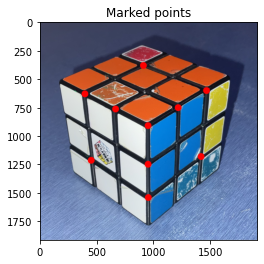

In [39]:
mark_rubic = rubic.copy()
for i in ic:
    mark_rubic = cv2.circle(mark_rubic, i.astype(int), radius=30, color=(255,0,0), thickness=-1)
plt.title("Marked points")
plt.imshow(mark_rubic)
plt.show()

In [40]:
P_d = DLT(wc, ic)
print("P from DLT:\n", P_d)
wc_homo = np.hstack((wc, np.ones((len(wc),1))))
err = compute_error(P_d, wc_homo, ic)
print("Error(MSE):", np.mean(err))

P from DLT:
 [[ 3.53652376e+02  5.40592697e+01 -2.49031190e+02  9.48682226e+02]
 [-1.16406596e+02  3.97727748e+02 -9.90298411e+01  9.15138291e+02]
 [ 6.87053393e-02  5.57045109e-02  6.81118690e-02  1.00000000e+00]]
Error(MSE): 23.705355545356163


In [41]:
P_r = RANSAC(wc, ic, n_iter=100)
print("P from RANSAC:\n", P_r)
wc_homo = np.hstack((wc, np.ones((len(wc),1))))
err = compute_error(P_r, wc_homo, ic)
print("Error(MSE):", np.mean(err))

P from RANSAC:
 [[ 3.60626868e+02  5.94740480e+01 -2.49684148e+02  9.48288561e+02]
 [-1.16391670e+02  4.05418891e+02 -9.76771931e+01  9.18377080e+02]
 [ 7.18888145e-02  6.12966777e-02  7.18611314e-02  1.00000000e+00]]
Error(MSE): 33.73511322291305


Observations:
1. Similar to the first example DLT offers lower error than the RANSAC variant
2. The parameters of the camera matrix generated from the DLT and the RANSAC variants are numerically the same

In [44]:
import glob

g = np.meshgrid(np.arange(6), np.arange(9), 0)
vx, vy, vz = list(map(lambda x: x.flatten(), g)) 
wc_temp = np.vstack((vx, vy, vz)).T

ic = []
wc = []

filenames = glob.glob('../images/IMG_00*.png')
for file in filenames:
    print(file)
    ret, corners = cv2.findChessboardCorners(cv2.imread(file, cv2.IMREAD_GRAYSCALE), (6,9))
    if ret:
        ic.append(corners)
        wc.append(wc_temp)

ic = np.array(ic, 'f').squeeze()
wc = np.array(wc, 'f')

print(ic.shape, wc.shape)

../images/IMG_0050.png
../images/IMG_0052.png
../images/IMG_0057.png
../images/IMG_0053.png
../images/IMG_0058.png
../images/IMG_0054.png
../images/IMG_0051.png
../images/IMG_0055.png
../images/IMG_0056.png
(9, 54, 2) (9, 54, 3)


In [45]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(wc, ic, (2016, 1512), None, None)
print('Camera Matrix:\n', mtx)
print('Reprojection error:\n', ret)

Camera Matrix:
 [[3.17625144e+03 0.00000000e+00 9.76947934e+02]
 [0.00000000e+00 3.17362728e+03 5.83304714e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Reprojection error:
 3.0838834290062405
